# Check GPU

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sat Dec 12 06:11:42 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Run this command once and restart the runtime

In [1]:
!pip install av

     |████████████████████████████████| 36.9MB 138kB/s 


# Mount drive


In [6]:
import os
import io
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'

drive.mount(DRIVE_MOUNT)


# create folder to write data to
DATA_FOLDER = os.path.join(DRIVE_MOUNT, 'Shared drives', 'CIS680 Final Project', 'data')
TRAIN_FOLDER = os.path.join(DATA_FOLDER, 'dataset_1', 'train')
TEST_FOLDER = os.path.join(DATA_FOLDER, 'dataset_1', 'test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model

In [4]:
import torch
from torch.nn import functional as F
from torchvision import transforms
from torch import nn, Tensor
# from dataset import *
import random
import torchvision
import torchvision.models as models
import torch.optim as optim


class SpatialStream(torch.nn.Module):

    def __init__(self, 
                 device='cuda',
                 num_classes=51,
                 dropout_probability=0.5,
                 train_resnet=True):

        # Initialize the stream layers
        super(SpatialStream, self).__init__()
        self.device = device
        self.num_classes = num_classes

        # Spatial Backbone
        self.spatial = models.resnet50(pretrained=True)
        for param in self.spatial.parameters():
            param.requires_grad = train_resnet  # False: Freezes the weights of the pre-trained model

        # Add to Spatial Backbone
        self.spatial.fc = nn.Sequential(nn.Linear(2048, 1024),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Linear(1024, self.num_classes),
                                nn.ReLU(),
                                nn.Dropout(p=dropout_probability),
                                nn.Softmax())

    def forward(self, X):
        return self.spatial(X)

    def compute_loss(self, output, labels):
        criterion = nn.CrossEntropyLoss()
        # labels = torch.tensor(labels)

        loss = criterion(output, labels)
        return loss

# Cache data

In [7]:
data_train = []
data_test = []
for iter in range(b_train):
  data_train.append(torch.load(TRAIN_FOLDER + '/train_b{}.pt'.format(iter)))
  if iter%5==0:
    print(iter)
for iter in range(b_test):
  data_test.append(torch.load(TEST_FOLDER + '/test_b{}.pt'.format(iter)))
  if iter%5==0:
    print(iter)

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
0
5
10
15
20
25
30
35
40


# Train & Test Functions

In [8]:
import torchvision.transforms as tf
trans = tf.RandomHorizontalFlip()
b_train = 146
n_train = 18665
b_test = 43
n_test = 5477
batch_size = 128

def train(epoch):
    
    spatial.train()
    counter = 0
    train_loss = 0
    log_interval = 25
    save_interval = 50

    epoch_loss = []
    log_int_loss = 0
    num_iter = 0

    for iter in range(b_train):
        data = data_train[iter]#torch.load(TRAIN_FOLDER + '/train_b{}.pt'.format(iter))

        videos = data["videos"].clone().squeeze(1).permute(0, 3, 1, 2)
        videos = trans(videos)
        labels = torch.tensor(data["labels"].copy())

        num_iter+=videos.shape[0]

        videos = videos.type(torch.FloatTensor)
        videos = videos.to(device)
        # labels = labels.to(device)

        optimizer.zero_grad()

        output = spatial(videos)
        output = output.to(device)
        labels = labels.to(device)

        # calculate losses
        loss = spatial.compute_loss(output, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Logging Interval
        log_int_loss += loss.item()
        epoch_loss.append(loss.item())

        if counter == 0:
            print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss)
            train_loss_list.append(train_loss / num_iter)
            train_counter.append(num_iter + epoch * n_train)
            log_int_loss = 0
        elif counter % log_interval == log_interval - 1:
            print('Epoch: ', epoch, ', Batch: ', iter, ', loss avg over log interval: ', log_int_loss / log_interval)
            train_loss_list.append(train_loss / num_iter)
            train_counter.append(num_iter + epoch * n_train)
            log_int_loss = 0

        if counter % save_interval == save_interval - 1 or counter==b_train-1:
            print('saving model')
            save_path = os.path.join(EPOCH_SAVE_PREFIX, 'spatial_epoch' + str(epoch) + '_iter_' + str(counter))
            torch.save({
                'epoch': epoch,
                'train_total_loss_list': train_loss_list,
                'epoch_total_loss_list': epoch_loss_list,
                'test_loss_list': test_loss_list,
                'train_counter': train_counter,
                'accuracy_list': accuracy_list,
                'model_state_dict': spatial.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)

        counter += 1


    avg_loss = sum(epoch_loss) / len(epoch_loss)
    epoch_loss_list.append(avg_loss)
    print('Epoch: ', epoch, ', avg total loss: ', avg_loss)

def test():
    spatial.eval()
    test_loss = 0
    correct = 0

    # Data Loop
    with torch.no_grad():
        for iter in range(b_test):
            data = data_test[iter]#torch.load(TRAIN_FOLDER + '/test_b{}.pt'.format(iter))
            videos = data["videos"].clone().squeeze(1).permute(0, 3, 1, 2)
            labels = torch.tensor(data["labels"].copy())

            videos = videos.type(torch.FloatTensor)
            videos = videos.to(device)
            labels = labels.to(device)

            output = spatial(videos)
            output = output.to(device)

            # calculate losses
            loss = spatial.compute_loss(output, labels)

            test_loss += loss.item()

            # calculate number of correct predictions in batch
            correct += sum(torch.argmax(output,1) == labels).item()
            if iter % 100 == 0:
                print ("iter  ", iter)
                print("accuracy so far = ", correct / ((iter + 1) * len(labels)))

    # Log
    test_loss_list.append(test_loss / n_test)
    accuracy = correct / n_test
    accuracy_list.append(accuracy)
    print('Avg Validation Loss: ', test_loss / n_test)
    print('Accuracy: ', accuracy)

# Main Training Loop

In [ ]:
import numpy as np
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_new/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# model
learning_rate = 0.001
spatial = SpatialStream()
spatial.to(device)
optimizer = optim.SGD(spatial.parameters(), lr=learning_rate, momentum=0.9)

# initialize weights
# for m in spatial.modules():
#     if isinstance(m, torch.nn.Linear):
#         torch.nn.init.normal_(m.weight, mean = 0, std = 0.01)
#         torch.nn.init.constant_(m.bias, 0)

# Epochs
num_epochs = 100++
;//+;*6333-++++++++++++++
# Logging setup: train
train_loss_list = []
epoch_loss_list = []
train_counter = []

# Logging setup: test
test_loss_list = []
accuracy_list = []
epoch_list = np.arange(num_epochs)

# epoch loop
for epoch in range(num_epochs):

    # Train & Validate
    train(epoch)
    test()

    # Adjust Learning Rate
    # if epoch == 8 or epoch == 13:
    #     pass

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'spatial_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_list': accuracy_list,
        'model_state_dict': spatial.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  0 , Batch:  0 , loss avg over log interval:  3.9316935539245605
Epoch:  0 , Batch:  24 , loss avg over log interval:  3.7745861434936523
Epoch:  0 , Batch:  49 , loss avg over log interval:  3.9320147800445557
saving model
Epoch:  0 , Batch:  74 , loss avg over log interval:  3.931882858276367
Epoch:  0 , Batch:  99 , loss avg over log interval:  3.9316771697998045
saving model
Epoch:  0 , Batch:  124 , loss avg over log interval:  3.93158164024353
saving model
Epoch:  0 , avg total loss:  3.9317470348044616
iter   0
accuracy so far =  0.71875
Avg Validation Loss:  0.030866728922474964
Accuracy:  0.04619317144422129
Epoch 0/99 Completed
Epoch:  1 , Batch:  0 , loss avg over log interval:  3.931469440460205
Epoch:  1 , Batch:  24 , loss avg over log interval:  3.774281129837036
Epoch:  1 , Batch:  49 , loss avg over log interval:  3.9311986637115477
saving model
Epoch:  1 , Batch:  74 , loss avg over log interval:  3.9310523414611818
Epoch:  1 , Batch:  99 , loss avg over log in

# Resume Training

In [ ]:
EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_new/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# model
learning_rate = 0.001
spatial = SpatialStream()
spatial.to(device)
optimizer = optim.SGD(spatial.parameters(), lr=learning_rate, momentum=0.9)

# initialize weights
# for m in spatial.modules():
#     if isinstance(m, torch.nn.Linear):
#         torch.nn.init.normal_(m.weight, mean = 0, std = 0.01)
#         torch.nn.init.constant_(m.bias, 0)

# Epochs
num_epochs = 100
epoch_list = np.arange(num_epochs)

# Load params
last_epoch = 69

# load data
network_path = EPOCH_SAVE_PREFIX + 'spatial_epoch{}'.format(last_epoch)
checkpoint = torch.load(network_path)
spatial.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']

# Logging setup: train
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_list']
train_counter = checkpoint['train_counter']


# epoch loop
for epoch in range(last_epoch + 1, num_epochs):

    # Train & Validate
    train(epoch)
    test()

    # Adjust Learning Rate
    # if epoch == 8 or epoch == 13:
    #     pass

    # Save Model Version
    save_path = os.path.join(EPOCH_SAVE_PREFIX, 'spatial_epoch' + str(epoch))
    torch.save({
        'epoch': epoch,
        'train_total_loss_list': train_loss_list,
        'epoch_total_loss_list': epoch_loss_list,
        'test_loss_list': test_loss_list,
        'train_counter': train_counter,
        'accuracy_list': accuracy_list,
        'model_state_dict': spatial.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, save_path)

    print("Epoch %d/%d Completed" % (epoch, num_epochs - 1))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch:  9 , Batch:  0 , loss avg over log interval:  3.579054117202759
Epoch:  9 , Batch:  99 , loss avg over log interval:  3.5460293793678286
Epoch:  9 , Batch:  199 , loss avg over log interval:  3.5823871088027954
saving model
Epoch:  9 , Batch:  299 , loss avg over log interval:  3.5742266011238097
Epoch:  9 , Batch:  399 , loss avg over log interval:  3.578859972953796
Epoch:  9 , Batch:  499 , loss avg over log interval:  3.5777490186691283
saving model
Epoch:  9 , Batch:  599 , loss avg over log interval:  3.579861807823181
Epoch:  9 , Batch:  699 , loss avg over log interval:  3.5729906296730043
saving model
Epoch:  9 , Batch:  799 , loss avg over log interval:  3.57385466337204
Epoch:  9 , Batch:  899 , loss avg over log interval:  3.5813414573669435
Epoch:  9 , Batch:  999 , loss avg over log interval:  3.576751308441162
saving model
Epoch:  9 , Batch:  1099 , loss avg over log interval:  3.5745735216140746
Epoch:  9 , Batch:  1199 , loss avg over log interval:  3.5685772466

# Calculate Accuracy of a Saved Model

In [ ]:
# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model
learning_rate = 0.001
spatial = SpatialStream()
spatial.to(device)
optimizer = optim.SGD(spatial.parameters(), lr=learning_rate, momentum=0.9)

# Load params
last_epoch = 69

# load data
network_path = EPOCH_SAVE_PREFIX + 'spatial_epoch{}'.format(last_epoch)
checkpoint = torch.load(network_path)
spatial.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
last_epoch = checkpoint['epoch']

# Logging setup: train
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
test_loss_list = checkpoint['test_loss_list']
train_counter = checkpoint['train_counter']

test()

/usr/local/lib/python3.6/dist-packages/torchvision/io/video.py:117: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0
1
2
3
4
5
6
7
8
9
10
iter   10
accuracy so far =  1.0
Avg Validation Loss:  0.0002464993757317368
Accuracy:  0.009755083659542037


# Plotting

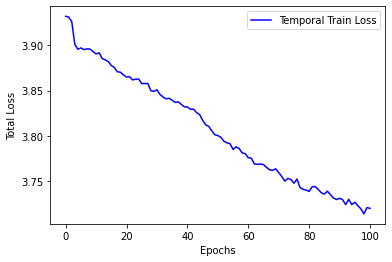

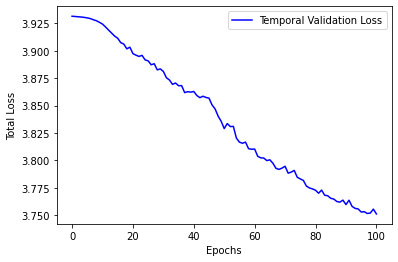

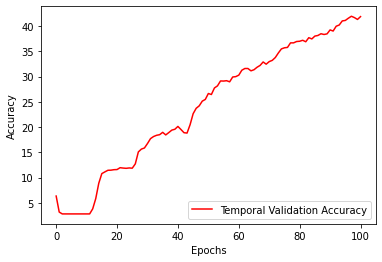

In [ ]:
import matplotlib.pyplot as plt


EPOCH_SAVE_PREFIX = '/content/drive/Shared drives/CIS680 Final Project/models/spatial_new/'

# Device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.random.manual_seed(1)

# Load params
last_epoch = 69

# load data
network_path = EPOCH_SAVE_PREFIX + 'spatial_epoch{}'.format(last_epoch)
checkpoint = torch.load(network_path)
train_loss_list = checkpoint['train_total_loss_list']
epoch_loss_list = checkpoint['epoch_total_loss_list']
train_counter = checkpoint['train_counter']
test_loss_list = checkpoint['test_loss_list']
accuracy_list = checkpoint['accuracy_lsit']
epoch_list = np.arange(last_epoch+1)


# plots
fig = plt.figure()
plt.plot(epoch_loss_list, color='blue')
plt.legend(['Spatial Train Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(test_loss_list, color='green')
plt.legend(['Spatial Validation Loss'], loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')

fig = plt.figure()
plt.plot(accuracy_list, color='red')
plt.legend(['Spatial Validation Accuracy'], loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.show()